In [1]:
%pylab inline
from train import train_simple
from models import *
from datasets import UnlabelledDataSet

/Users/wellecks/own_files/env/minpy_dev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


### Visualize Approximate Posterior for Simple Dataset

4 point, 4 class dataset

In [2]:
data = np.array([[-1.,-1.], [-1., 1.], [1., -1.], [1., 1.]])

In [26]:
def run_simple(enc, data, flow=None, **kwargs):
    tf.reset_default_graph()

    dim_x, dim_z, enc_dims, dec_dims = data.shape[1], 2, [100, 100], [100, 100]
    encoder_net = lambda x: nn(x, enc_dims, name='encoder', act=tf.nn.tanh)
    decoder_net = lambda z: nn(z, dec_dims, name='decoder', act=tf.nn.tanh)

    if flow is None:
        encoder = enc(encoder_net, dim_z)
    else:
        encoder = enc(encoder_net, dim_z, flow=flow)
    decoder = basic_decoder(decoder_net, dim_x, act=None)

    extra_settings = {
        'flow length': flow,
        'encoder structure': enc_dims,
        'decoder structure': dec_dims,
        'anneal_lr': False
    }

    ops, sess = train_simple(
                    dim_x=dim_x, 
                    dim_z=dim_z, 
                    encoder=encoder, 
                    decoder=decoder, 
                    training_dataset=UnlabelledDataSet(data), 
                    rec_err_type='l2_loss',
                    **kwargs
    )
    return ops, sess

def plot_results(ops, data):
    # Posterior samples
    samples = 500
    dim_z = 2

    x_ = np.repeat(data, samples, axis=0)
    y_ = np.repeat(np.arange(data.shape[0]), samples)
    e_ = np.random.normal(size=(x_.shape[0], dim_z))
    zs = sess.run(ops['z'], feed_dict={ops['x']: x_, ops['e']: e_})
    
    # Reconstructions
    e_ = np.random.normal(size=(data.shape[0], dim_z))
    x_rec = sess.run(ops['out'], feed_dict={ops['x']: data, ops['e']: e_})

    # Plot samples on left and reconstructions on right
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].scatter(zs[:, 0], zs[:, 1], c=y_)
    axs[0].set_title('Posterior samples for each datapoint')
    
    axs[1].scatter(x_rec[:, 0], x_rec[:, 1], c=np.arange(data.shape[0]));
    axs[1].set_title('Reconstructed data')
    plt.show()

#### Vanilla VAE

In [27]:
ops, sess = run_simple(basic_encoder, data, max_epochs=10000, print_every=2500)

Epoch: 0	 Training loss: 411.88, Validation loss 0.00 (0.0)
Epoch: 2500	 Training loss: 7.21, Validation loss 0.00 (0.0)
Epoch: 5000	 Training loss: 5.46, Validation loss 0.00 (0.0)
Epoch: 7500	 Training loss: 4.20, Validation loss 0.00 (0.0)


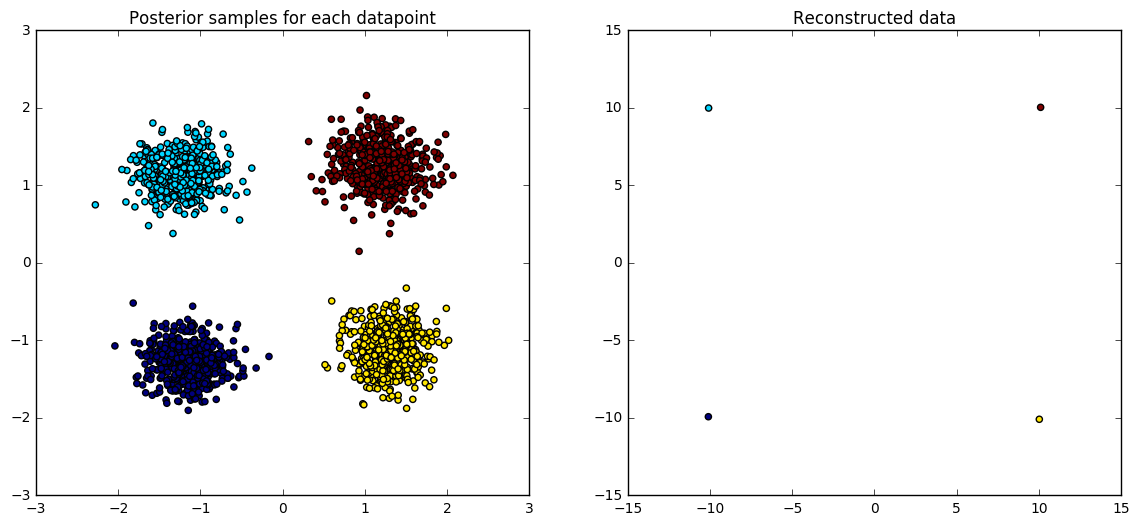

In [28]:
plot_results(ops, data)

#### IAF 1 step

In [31]:
ops, sess = run_simple(iaf_encoder, data, flow=1, max_epochs=10000, print_every=2500)

Epoch: 0	 Training loss: 395.39, Validation loss 0.00 (0.1)
Epoch: 2500	 Training loss: 5.00, Validation loss 0.00 (0.0)
Epoch: 5000	 Training loss: 3.81, Validation loss 0.00 (0.0)
Epoch: 7500	 Training loss: 2.76, Validation loss 0.00 (0.0)


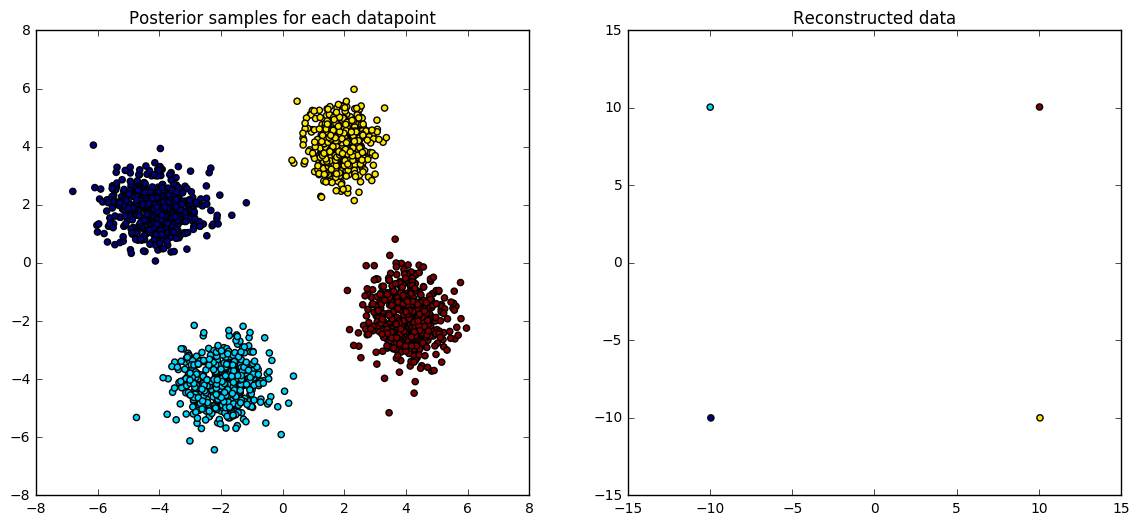

In [32]:
plot_results(ops, data)

#### NF 10 steps

In [52]:
ops, sess = run_simple(nf_encoder, data, flow=10)

Epoch: 0	 Training loss: 410.26, Validation loss 0.00 (0.2)
Epoch: 1000	 Training loss: 7.27, Validation loss 0.00 (0.0)
Epoch: 2000	 Training loss: 6.52, Validation loss 0.00 (0.0)
Epoch: 3000	 Training loss: 6.21, Validation loss 0.00 (0.0)
Epoch: 4000	 Training loss: 6.23, Validation loss 0.00 (0.0)
Epoch: 5000	 Training loss: 11.07, Validation loss 0.00 (0.0)
Epoch: 6000	 Training loss: 6.97, Validation loss 0.00 (0.0)
Epoch: 7000	 Training loss: 308.45, Validation loss 0.00 (0.0)
Epoch: 8000	 Training loss: 4.23, Validation loss 0.00 (0.0)
Epoch: 9000	 Training loss: 5.54, Validation loss 0.00 (0.0)


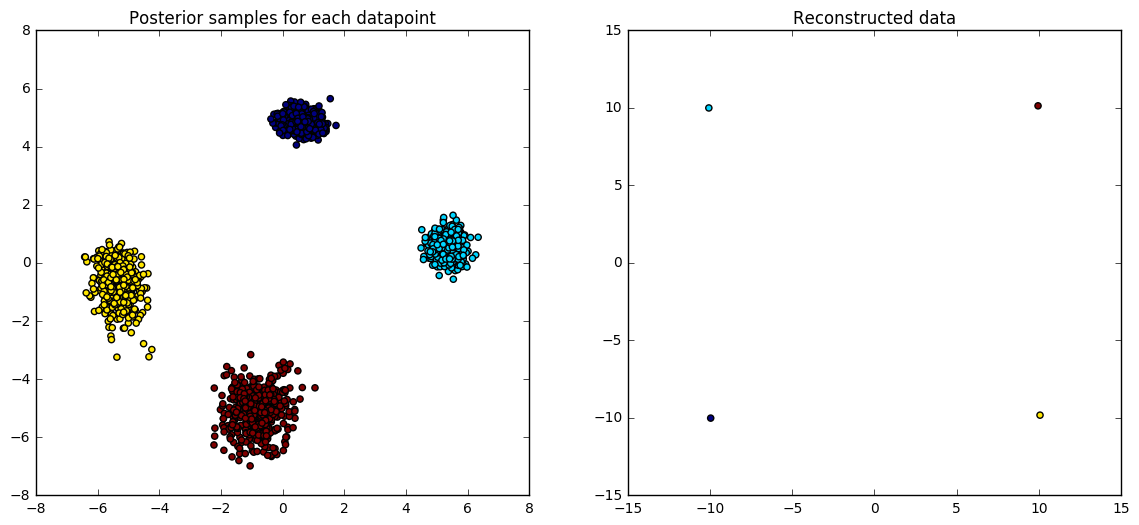

In [55]:
plot_results(ops, data)

### Mixture Model

In [17]:
def plot_results(ops, data, labels):
    samples = 500
    dim_z = 2
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))
    
    # Posterior Samples
    # Take a data point from each class
    x_ = np.repeat(data[[(ys==i).argmax() for i in range(3)]], samples, axis=0)
    y_ = np.repeat(np.arange(3), samples)
    e_ = np.random.normal(size=(x_.shape[0], dim_z))
    zs = sess.run(ops['z'], feed_dict={ops['x']: x_, ops['e']: e_})
    axs[0].scatter(zs[:, 0], zs[:, 1], c=y_)
    axs[0].set_title("Posterior samples for 3 data points")
    
    # Latent z values for each data point
    x_ = data
    e_ = np.random.normal(size=(x_.shape[0], dim_z))
    zs = sess.run(ops['z'], feed_dict={ops['x']: x_, ops['e']: e_})
    axs[1].scatter(zs[:, 0], zs[:, 1], c=labels)
    axs[1].set_title('latent z values for each data point')
    
    # Reconstructions
    e_ = np.random.normal(size=(data.shape[0], dim_z))
    x_rec = sess.run(ops['out'], feed_dict={ops['x']: data, ops['e']: e_})
    axs[2].scatter(x_rec[:, 0], x_rec[:, 1], c=labels);
    axs[2].set_title('Reconstructed data')
    
    plt.show()

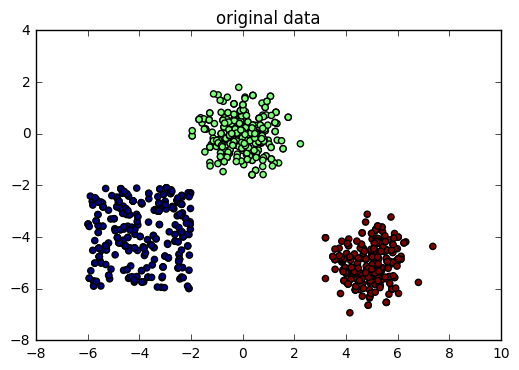

In [7]:
N = 1000
xs = np.vstack((
    np.random.uniform(-6, -2, size=(N/3, 2)),
    np.random.multivariate_normal([0, 0], np.eye(2)/2, size=N/3),
    np.random.multivariate_normal([5, -5], np.eye(2)/2, size=N/3)
))
ys = np.repeat(np.arange(3), N/3)


idxs = np.random.choice(range(xs.shape[0]), xs.shape[0])
xs, ys = xs[idxs], ys[idxs]

plt.scatter(xs[:, 0], xs[:, 1], c=ys)
plt.title('original data');

#### Vanilla VAE

In [20]:
ops, sess = run_simple(basic_encoder, xs, max_epochs=500, print_every=100)

Epoch: 0	 Training loss: 1160.57, Validation loss 0.00 (0.1)
Epoch: 100	 Training loss: 8.69, Validation loss 0.00 (0.0)
Epoch: 200	 Training loss: 8.06, Validation loss 0.00 (0.0)
Epoch: 300	 Training loss: 8.29, Validation loss 0.00 (0.0)
Epoch: 400	 Training loss: 7.77, Validation loss 0.00 (0.0)


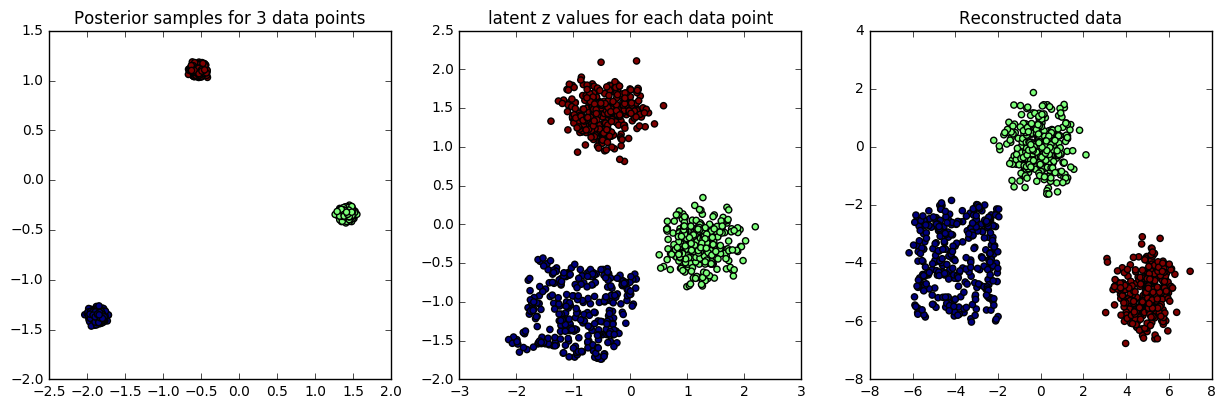

In [21]:
plot_results(ops, xs, ys)

#### IAF Flow 1

In [8]:
ops, sess = run_simple(iaf_encoder, xs, flow=1, max_epochs=500, print_every=100)

Epoch: 0	 Training loss: 1047.84, Validation loss 0.00 (0.1)
Epoch: 100	 Training loss: 9.45, Validation loss 0.00 (0.1)
Epoch: 200	 Training loss: 8.46, Validation loss 0.00 (0.0)
Epoch: 300	 Training loss: 8.36, Validation loss 0.00 (0.1)
Epoch: 400	 Training loss: 8.16, Validation loss 0.00 (0.1)


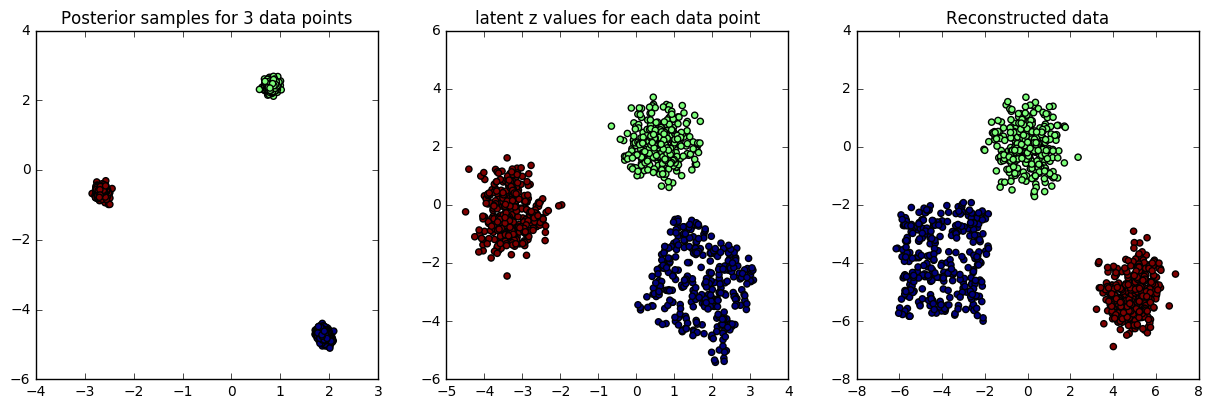

In [18]:
plot_results(ops, xs, ys)

#### NF Flow 10

In [24]:
ops, sess = run_simple(nf_encoder, xs, flow=10, max_epochs=2000, print_every=100)

Epoch: 0	 Training loss: 911.83, Validation loss 0.00 (0.3)
Epoch: 100	 Training loss: 20.38, Validation loss 0.00 (0.1)
Epoch: 200	 Training loss: 14.23, Validation loss 0.00 (0.1)
Epoch: 300	 Training loss: 12.12, Validation loss 0.00 (0.2)
Epoch: 400	 Training loss: 10.88, Validation loss 0.00 (0.1)
Epoch: 500	 Training loss: 10.56, Validation loss 0.00 (0.1)
Epoch: 600	 Training loss: 10.61, Validation loss 0.00 (0.1)
Epoch: 700	 Training loss: 10.33, Validation loss 0.00 (0.1)
Epoch: 800	 Training loss: 9.90, Validation loss 0.00 (0.1)
Epoch: 900	 Training loss: 9.95, Validation loss 0.00 (0.1)
Epoch: 1000	 Training loss: 9.42, Validation loss 0.00 (0.1)
Epoch: 1100	 Training loss: 9.27, Validation loss 0.00 (0.1)
Epoch: 1200	 Training loss: 9.10, Validation loss 0.00 (0.1)
Epoch: 1300	 Training loss: 8.96, Validation loss 0.00 (0.1)
Epoch: 1400	 Training loss: 8.73, Validation loss 0.00 (0.1)
Epoch: 1500	 Training loss: 8.58, Validation loss 0.00 (0.1)
Epoch: 1600	 Training loss:

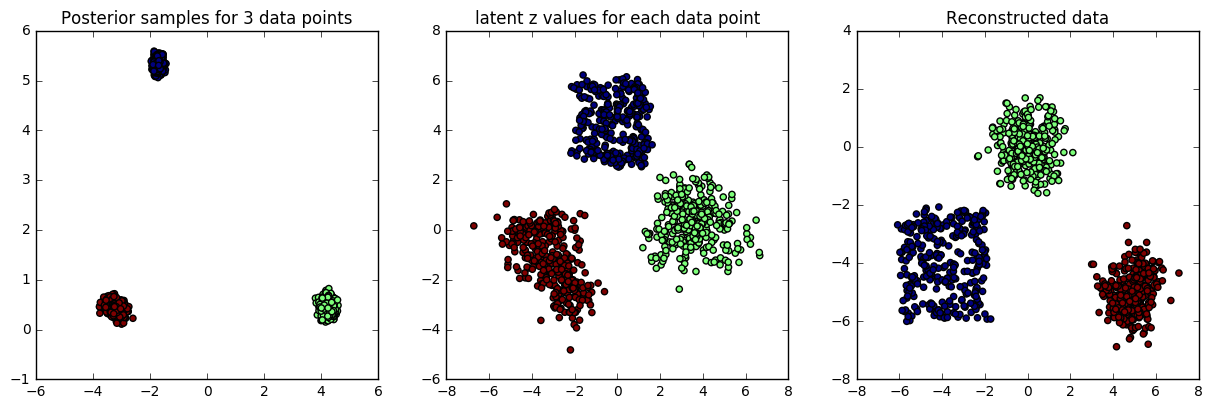

In [25]:
plot_results(ops, xs, ys)